In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv("The Beatles dataset.csv")

In [3]:
df.head()

,C,C#,D,D#,E,F,F#,G,G#,A,A#,B,title,chords
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,01 A Hard Day's Night,N
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,01 A Hard Day's Night,N
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,01 A Hard Day's Night,N
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,01 A Hard Day's Night,N
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,01 A Hard Day's Night,N


In [4]:
titles=df.title.unique()

In [5]:
ex_title=titles[104]
print(ex_title)

12 I Want To Tell You


In [6]:
chroma=df[df.title==ex_title].iloc[:,0:12].to_numpy().transpose()
chord_reference_literal=df[df.title==ex_title].chords.to_list()
print("chroma.shape = ",chroma.shape,"chord_reference_literal len = ",len(chord_reference_literal))

chroma.shape =  (12, 1594) chord_reference_literal len =  1594


In [7]:
# DA SISTEMARE
def omologous(root):
    flats=["Cb","Db","Eb","Fb","Gb","Ab","Bb"]
    omo=["B","C#","D#","E","F#","G#","A#"]
    if root in flats:
        return omo[flats.index(root)]
    else:
        return root
    
def chord_to_triad(lab):
    triads_labs=["C","C#","D","D#","E","F","F#","G","G#","A","A#","B","C:min","C#:min","D:min","D#:min","E:min","F:min","F#:min","G:min","G#:min","A:min","A#:min","B:min"]
    separated_lab=lab.split(":")
    n=len(separated_lab)
    if n==1:
        return omologous(lab.split("/")[0])
    else:
        root=separated_lab[0]
        if separated_lab[1][0].isdigit():
            return omologous(root.split("/")[0])
        elif separated_lab[1][:3]=="min" or separated_lab[1][:3]=="dim":
            return omologous(root.split("/")[0])+":min"
        else:
            return omologous(root.split("/")[0])
  

In [8]:
chord_reference_literal_reduced=[]
for ii in range(len(chord_reference_literal)):
    chord_reference_literal_reduced.append(chord_to_triad(chord_reference_literal[ii]))
ref_annotations=[] # they are literal

In [9]:
possible=["N","C","C#","D","D#","E","F","F#","G","G#","A","A#","B","C:min","C#:min","D:min","D#:min","E:min","F:min","F#:min","G:min","G#:min","A:min","A#:min","B:min"]
print([x for x in chord_reference_literal_reduced if x not in possible])
print(set(chord_reference_literal_reduced)-set(["N","C","C#","D","D#","E","F","F#","G","G#","A","A#","B","C:min","C#:min","D:min","D#:min","E:min","F:min","F#:min","G:min","G#:min","A:min","A#:min","B:min"]))

[]
set()


In [10]:
# CHecking for all
df=pd.read_csv("The Beatles dataset.csv")
all_chords=df.chords.to_list()
all_reduced=[]
for ii in range(len(all_chords)):
    all_reduced.append(chord_to_triad(all_chords[ii]))

In [11]:
possible=["N","C","C#","D","D#","E","F","F#","G","G#","A","A#","B","C:min","C#:min","D:min","D#:min","E:min","F:min","F#:min","G:min","G#:min","A:min","A#:min","B:min"]
print([x for x in all_reduced if x not in possible])
print(set(all_reduced)-set(possible))

[]
set()


## Let's start

In [8]:
import librosa
import librosa.feature as feat

import ntpath

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn import neighbors

In [14]:
# Everything from tutorial file
major_labs=["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]
minor_labs=["C:min","C#:min","D:min","D#:min","E:min","F:min","F#:min","G:min","G#:min","A:min","A#:min","B:min"]
dominant7_labs=["C:7","C#:7","D:7","D#:7","E:7","F:7","F#:7","G:7","G#:7","A:7","A#:7","B:7"]
major7_labs=["C:maj7","C#:maj7","D:maj7","D#:maj7","E:maj7","F:maj7","F#:maj7","G:maj7","G#:maj7","A:maj7","A#:maj7","B:maj7"]
minor7_labs=["C:min7","C#:min7","D:min7","D#:min7","E:min7","F:min7","F#:min7","G:min7","G#:min7","A:min7","A#:min7","B:min7"]

#chords_labs=major_labs+minor_labs+dominant7_labs#+major7_labs+minor7_labs

chroma_labs=["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]

def chroma_note_harmonics(root,alpha):
    model=np.array([1+alpha+alpha**3+alpha**7,
                   0,
                   0,
                   0,
                   alpha**4,
                   0,
                   0,
                   alpha**2+alpha**5,
                   0,
                   0,
                   alpha**6,
                   0])
    chroma=np.roll(model, root)
    return chroma

def chroma_chords(alpha,major=True,minor=True,dominant7=False,major7=False,minor7=False):
    chords=np.zeros(shape=(12,major*12+minor*12+dominant7*12+major7*12+minor7*12))
    labs=[]
    for i in range(12): #loop on possible root notes
        if major:
            chords[:,i]=chroma_note_harmonics(root=i,alpha=alpha)+chroma_note_harmonics(root=i+4,alpha=alpha)+chroma_note_harmonics(root=i+7,alpha=alpha)
            labs=labs+major_labs
        if minor:
            chords[:,major*12+i]=chroma_note_harmonics(root=i,alpha=alpha)+chroma_note_harmonics(root=i+3,alpha=alpha)+chroma_note_harmonics(root=i+7,alpha=alpha)
            labs=labs+minor_labs
        if dominant7:
            chords[:,major*12+minor*12+i]=chroma_note_harmonics(root=i,alpha=alpha)+chroma_note_harmonics(root=i+4,alpha=alpha)+chroma_note_harmonics(root=i+7,alpha=alpha)+chroma_note_harmonics(root=i+10,alpha=alpha)
            labs=labs+dominant7_labs
        if major7:
            chords[:,major*12+minor*12+dominant7*12+i]=chroma_note_harmonics(root=i,alpha=alpha)+chroma_note_harmonics(root=i+4,alpha=alpha)+chroma_note_harmonics(root=i+7,alpha=alpha)+chroma_note_harmonics(root=i+11,alpha=alpha)
            labs=labs+major7_labs
        if minor7:
            chords[:,major*12+minor*12+dominant7*12+major7*12+i]=chroma_note_harmonics(root=i,alpha=alpha)+chroma_note_harmonics(root=i+3,alpha=alpha)+chroma_note_harmonics(root=i+7,alpha=alpha)+chroma_note_harmonics(root=i+10,alpha=alpha)
            labs=labs+minor7_labs
    return (chords,labs)

def normalize_2(chroma):
    s=np.sum(chroma**2,axis=0)
    for i in range(len(s)):
        if s[i]>0:
            chroma[:,i]=chroma[:,i]/np.sqrt(s[i])
    return chroma

def temporal_smothing(chroma,n_win):
    chroma_sm=np.zeros(shape=chroma.shape)
    chr_pd=librosa.util.pad_center(chroma,chroma.shape[1]+n_win, axis=1)
    for n in range(chroma.shape[1]):
        chroma_sm[:,n]=np.sum(chr_pd[:,n:(n+n_win)],axis=1)*1/n_win
    return chroma_sm

def template_matching(chroma,chords):
    nvals=chroma.shape[1]
    nchords=chords.shape[1]
    est_chords=np.zeros(shape=nvals,dtype=int)
    est_dist=np.zeros(shape=nvals)
    dist=np.zeros(shape=nchords)
    for i in range(nvals):
        for ch in range(nchords):
            dist[ch]=np.linalg.norm(chroma[:,i]-chords[:,ch])
            est_chords[i]=np.argmin(dist)
            est_dist[i]=np.min(dist)
    return (est_chords,est_dist)

def n_different_chords(est_chords):
    curr=est_chords[0]
    N_chords=1
    for i in range(len(est_chords)):
        if est_chords[i] != curr:
            curr=est_chords[i]
            N_chords=N_chords+1
    return N_chords

def estimation_error(est_chords,annotated_chords):
    if len(est_chords)==len(annotated_chords):
        return sum(est_chords!=annotated_chords)/len(est_chords)
    else:
        print("ERROR: different lengths!")
        return None
    
def estimate_chords(music_input,template_chords,mu=False,n_win=False,post_smoothing=False):# can add also postprocessing features
    if type(music_input)==str:
        # open the file
        music,sr=librosa.load(music_input)
        # compute the chroma
        chroma=feat.chroma_stft(y=music,sr=sr,norm=2,hop_length=hop_length,n_fft=n_fft,tuning=0,octwidth=None)
    else: # music_input must be np.ndarry
        chroma=music_input
    # preprocessing:
    if mu: # compression
        chroma = librosa.mu_compress(chroma, quantize=False, mu=mu)
    if n_win: # temporal smoothing
        chroma=temporal_smothing(chroma,n_win=n_win)
    # normalize
    chroma=normalize_2(chroma)
    # template matching
    estimated,distance=template_matching(chroma,template_chords)
    # postprocessing
    if post_smoothing:
        clf = neighbors.KNeighborsClassifier(post_smoothing, weights='uniform')
        clf.fit(np.arange(len(estimated)).reshape(-1, 1),estimated)
        estimated = clf.predict(np.arange(len(estimated)).reshape(-1, 1))
    
    return estimated

In [10]:
df=pd.read_csv("The Beatles dataset.csv")

In [11]:
how_many_songs=2
titles_all=df.title.unique()
titles_selected=titles_all[:how_many_songs]
print(titles_selected)

["01 A Hard Day's Night" '02 I Should Have Known Better']


In [12]:
N_alphas=5
N_mus=4
N_n_wins=5

alphas=np.linspace(0,1,N_alphas)
mus=20*np.arange(N_mus)
n_wins=10*np.arange(N_n_wins)

error=np.zeros(shape=(N_alphas,N_mus,N_n_wins))
N_chords=np.zeros(shape=(N_alphas,N_mus,N_n_wins),dtype=int)

N_chords_annotation=0

for ttl in titles_selected:
    print(ttl)
    # Extract chroma from dataset
    chroma=df[df.title==ttl].iloc[:,0:12].to_numpy().transpose()
    # Extract reference chords annotations from dataset, convert it to triads strings (with 'N')
    chord_reference_extended=df[df.title==ttl].chords.to_list()
    ref_annotations_literal=[]
    for ii in range(len(chord_reference_extended)):
        ref_annotations_literal.append(chord_to_triad(chord_reference_extended[ii])) # they are literal, not numeric
    N_chords_annotation=N_chords_annotation+n_different_chords(ref_annotations_literal)
    # Analysis
    for i in range(N_alphas):
        alpha=alphas[i]
        chords,chords_labs=chroma_chords(alpha)
        chords_labs.append('N')
        ref_annotations=[]
        for ii in range(len(ref_annotations_literal)):
            ref_annotations.append(chords_labs.index(ref_annotations_literal[ii])) #they are now numeric, with N as 24+1=25
        for j in range(N_mus):
            mu=mus[j]
            print("alpha = "+str(alpha)+"; mu = "+str(mu),end="; n_win = ")
            for k in range(N_n_wins):
                n_win=n_wins[k]
                print(str(n_win),end=", ")
                estimated=estimate_chords(music_input=chroma,template_chords=chords,mu=mu,n_win=n_win)
                error[i,j,k]=error[i,j,k]+estimation_error(estimated,ref_annotations)
                N_chords[i,j,k]=N_chords[i,j,k]+n_different_chords(estimated)
            print("")
error=error/how_many_songs
N_chords=N_chords/how_many_songs
N_chords_annotation=N_chords_annotation/how_many_songs

01 A Hard Day's Night
alpha = 0.0; mu = 0; n_win = 0, 

C:\Users\franc\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


10, 20, 30, 40, 
alpha = 0.0; mu = 20; n_win = 0, 10, 20, 30, 40, 

KeyboardInterrupt: 

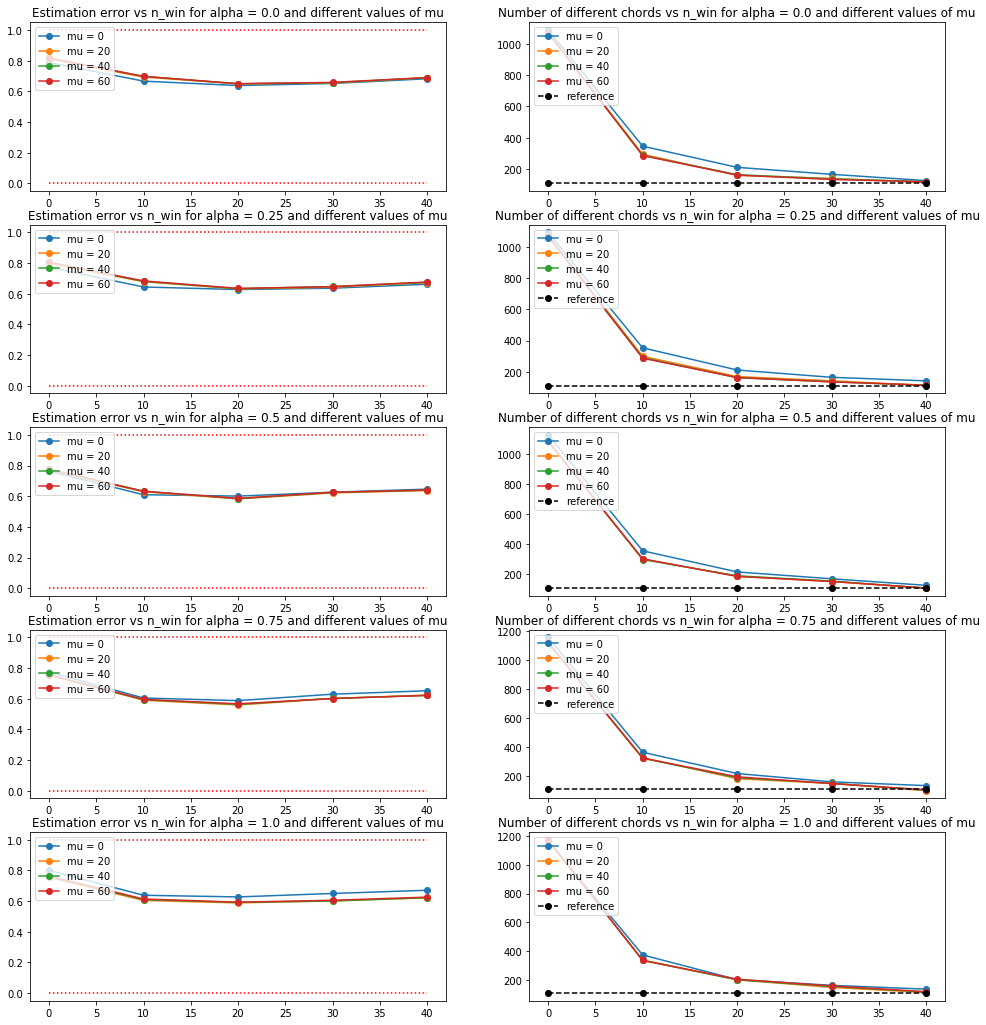

In [76]:
plt.figure(figsize=(16.4, 3.6*5))
#format_strings=['bo-','ro-','go-']

for i in range(N_alphas):
    alpha=alphas[i]
    plt.subplot(N_alphas,2,2*i+1)
    plt.plot(n_wins,np.zeros(shape=N_n_wins,dtype=int),'r:')
    plt.plot(n_wins,np.ones(shape=N_n_wins,dtype=int),'r:')
    for j in range(N_mus):
        mu=mus[j]
        plt.plot(n_wins,error[i,j,:],'o-',label="mu = "+str(mu))
    plt.title("Estimation error vs n_win for alpha = "+str(alpha)+" and different values of mu")
    plt.legend(loc='upper left')
    
for i in range(N_alphas):
    alpha=alphas[i]
    plt.subplot(N_alphas,2,2*i+2)
    for j in range(N_mus):
        mu=mus[j]
        plt.plot(n_wins,N_chords[i,j,:],'o-',label="mu = "+str(mu))
    plt.plot(n_wins,N_chords_annotation*np.ones(shape=N_n_wins,dtype=int),'ko--',label="reference")
    #plt.plot(n_wins,60*np.ones(shape=N_n_wins,dtype=int),'w:')
    plt.title("Number of different chords vs n_win for alpha = "+str(alpha)+" and different values of mu")
    plt.legend(loc='upper left') 

Try with values that were good on the example

In [18]:
how_many_songs=50
titles_all=df.title.unique()
titles_selected=titles_all[:how_many_songs]

N_alphas=1
N_mus=1
N_n_wins=1

error=0
N_chords=0

N_chords_annotation=0

for ttl in titles_selected:
    print(ttl)
    # Extract chroma from dataset
    chroma=df[df.title==ttl].iloc[:,0:12].to_numpy().transpose()
    # Extract reference chords annotations from dataset, convert it to triads strings (with 'N')
    chord_reference_extended=df[df.title==ttl].chords.to_list()
    ref_annotations_literal=[]
    for ii in range(len(chord_reference_extended)):
        ref_annotations_literal.append(chord_to_triad(chord_reference_extended[ii])) # they are literal, not numeric
    N_chords_annotation=N_chords_annotation+n_different_chords(ref_annotations_literal)
    # Analysis
    chords,chords_labs=chroma_chords(0)
    chords_labs.append('N')
    ref_annotations=[]
    for ii in range(len(ref_annotations_literal)):
        ref_annotations.append(chords_labs.index(ref_annotations_literal[ii])) #they are now numeric, with N as 24+1=25
    estimated=estimate_chords(music_input=chroma,template_chords=chords,mu=40,n_win=10,post_smoothing=15)
    error=error+estimation_error(estimated,ref_annotations)
    N_chords=N_chords+n_different_chords(estimated)
error=error/how_many_songs
N_chords=N_chords/how_many_songs
N_chords_annotation=N_chords_annotation/how_many_songs

print("Average error: "+str(error))
print("Average number of chords: "+str(N_chords))
print("Nominal average number of chords: "+str(N_chords_annotation))

01 A Hard Day's Night


C:\Users\franc\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


02 I Should Have Known Better
03 If I Fell
04 I'm Happy Just To Dance With You
05 And I Love Her
06 Tell Me Why
07 Can't Buy Me Love
08 Any Time At All
09 I'll Cry Instead
10 Things We Said Today
11 When I Get Home
12 You Can't Do That
13 I'll Be Back


C:\Users\franc\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


01 Come Together


C:\Users\franc\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


02 Something
03 Maxwell's Silver Hammer
04 Oh! Darling
05 Octopus's Garden
06 I Want You
07 Here Comes The Sun
08 Because
09 You Never Give Me Your Money
10 Sun King
11 Mean Mr Mustard
12 Polythene Pam
13 She Came In Through The Bathroom Window
14 Golden Slumbers
15 Carry That Weight
16 The End
17 Her Majesty
01 No Reply


C:\Users\franc\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
C:\Users\franc\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


02 I'm A Loser
03 Baby's In Black
04 Rock And Roll Music
05 I'll Follow The Sun
07 Kansas City- Hey, Hey, Hey, Hey
08 Eight Days a Week
09 Words of Love
10 Honey Don't
11 Every Little Thing
12 I Don't Want to Spoil the Party
13 What You're Doing
14 Everybody's Trying to Be My Baby


C:\Users\franc\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


01 Help!


C:\Users\franc\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


02 The Night Before
03 You've Got To Hide Your Love Away
04 I Need You
05 Another Girl
06 You're Going To Lose That Girl
07 Ticket To Ride
Average error: 0.698048629771132
Average number of chords: 121.46
Nominal average number of chords: 69.72


Fix mu=40 and try to add postprocessing

In [24]:
how_many_songs=2
titles_all=df.title.unique()
titles_selected=titles_all[70:70+how_many_songs]

# Fizing mu, making n_neighbor change
N_alphas=3
N_mus=1
N_n_wins=7
N_n_neighbors=6

alphas=np.linspace(0,1,11)[:N_alphas]
mu=40
n_wins=5*np.arange(N_n_wins)
n_neighborss=5*np.arange(N_n_neighbors)

error=np.zeros(shape=(N_alphas,N_n_neighbors,N_n_wins))
N_chords=np.zeros(shape=(N_alphas,N_n_neighbors,N_n_wins),dtype=int)

N_chords_annotation=0


for ttl in titles_selected:
    print(ttl)
    # Extract chroma from dataset
    chroma=df[df.title==ttl].iloc[:,0:12].to_numpy().transpose()
    # Extract reference chords annotations from dataset, convert it to triads strings (with 'N')
    chord_reference_extended=df[df.title==ttl].chords.to_list()
    ref_annotations_literal=[]
    for ii in range(len(chord_reference_extended)):
        ref_annotations_literal.append(chord_to_triad(chord_reference_extended[ii])) # they are literal, not numeric
    N_chords_annotation=N_chords_annotation+n_different_chords(ref_annotations_literal)
    # Analysis
    for i in range(N_alphas):
        alpha=alphas[i]
        chords,chords_labs=chroma_chords(alpha)
        chords_labs.append('N')
        ref_annotations=[]
        for ii in range(len(ref_annotations_literal)):
            ref_annotations.append(chords_labs.index(ref_annotations_literal[ii])) #they are now numeric, with N as 24+1=25
        for j in range(N_n_neighbors):
            n_neighbors=n_neighborss[j]
            print("alpha = "+str(alpha)+"; n_neighbors = "+str(n_neighbors),end="; n_win = ")
            for k in range(N_n_wins):
                n_win=n_wins[k]
                print(str(n_win),end=", ")
                estimated=estimate_chords(music_input=chroma,template_chords=chords,mu=mu,n_win=n_win,post_smoothing=n_neighbors)
                error[i,j,k]=error[i,j,k]+estimation_error(estimated,ref_annotations)
                N_chords[i,j,k]=N_chords[i,j,k]+n_different_chords(estimated)
            print("")
error=error/how_many_songs
N_chords=N_chords/how_many_songs
N_chords_annotation=N_chords_annotation/how_many_songs

02 The Fool On The Hill
alpha = 0.0; n_neighbors = 0; n_win = 0, 5, 10, 15, 20, 25, 30, 
alpha = 0.0; n_neighbors = 5; n_win = 0, 5, 10, 15, 20, 25, 30, 
alpha = 0.0; n_neighbors = 10; n_win = 0, 5, 10, 15, 20, 25, 30, 
alpha = 0.0; n_neighbors = 15; n_win = 0, 5, 10, 15, 20, 25, 30, 
alpha = 0.0; n_neighbors = 20; n_win = 0, 5, 10, 15, 20, 25, 30, 
alpha = 0.0; n_neighbors = 25; n_win = 0, 5, 10, 15, 20, 25, 30, 
alpha = 0.1; n_neighbors = 0; n_win = 0, 5, 10, 15, 20, 25, 30, 
alpha = 0.1; n_neighbors = 5; n_win = 0, 5, 10, 15, 20, 25, 30, 
alpha = 0.1; n_neighbors = 10; n_win = 0, 5, 10, 15, 20, 25, 30, 
alpha = 0.1; n_neighbors = 15; n_win = 0, 5, 10, 15, 20, 25, 30, 
alpha = 0.1; n_neighbors = 20; n_win = 0, 5, 10, 15, 20, 25, 30, 
alpha = 0.1; n_neighbors = 25; n_win = 0, 5, 10, 15, 20, 25, 30, 
alpha = 0.2; n_neighbors = 0; n_win = 0, 5, 10, 15, 20, 25, 30, 
alpha = 0.2; n_neighbors = 5; n_win = 0, 5, 10, 15, 20, 25, 30, 
alpha = 0.2; n_neighbors = 10; n_win = 0, 5, 10, 15, 20, 2

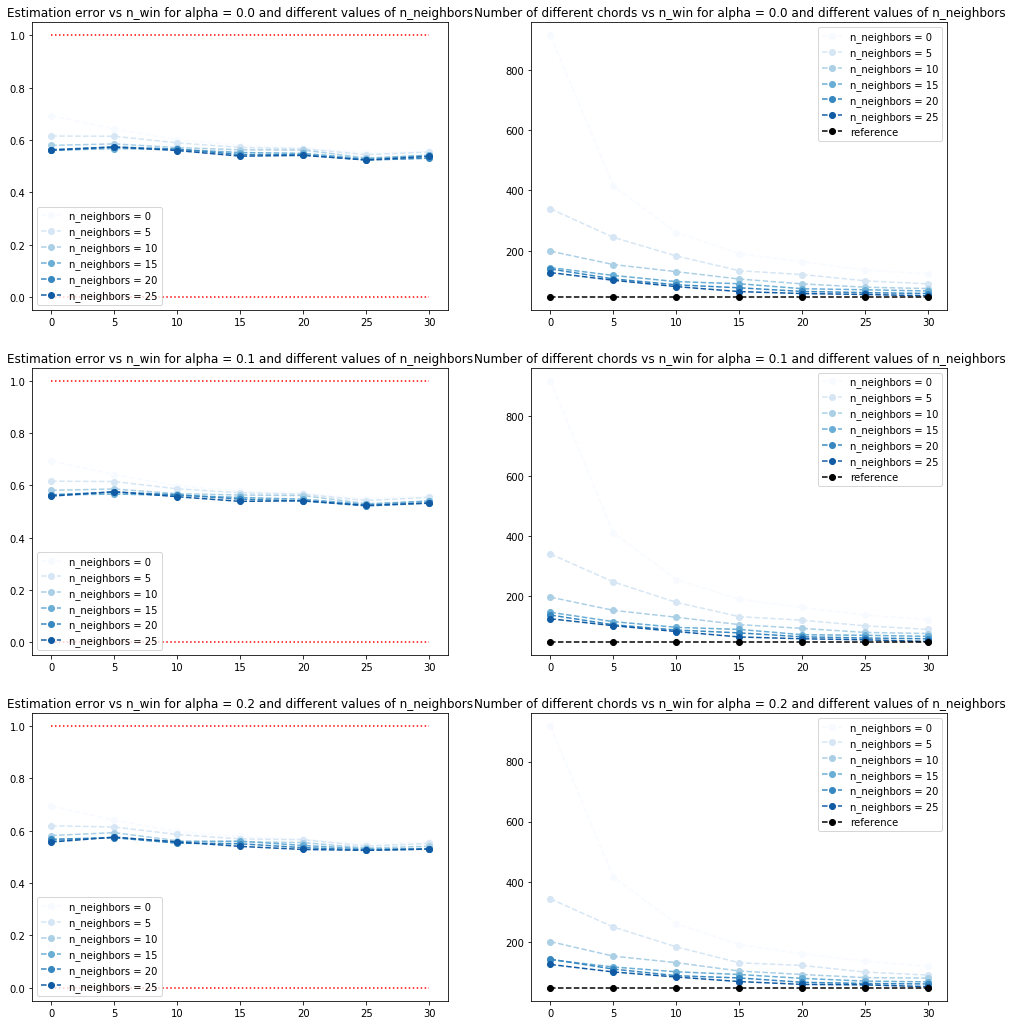

In [25]:
plt.figure(figsize=(16.4, 3.6*5))
#format_strings=['bo-','ro-','go-']
cmap = plt.get_cmap('Blues')

for i in range(N_alphas):
    alpha=alphas[i]
    plt.subplot(N_alphas,2,2*i+1)
    plt.plot(n_wins,np.zeros(shape=N_n_wins,dtype=int),'r:')
    plt.plot(n_wins,np.ones(shape=N_n_wins,dtype=int),'r:')
    for j in range(N_n_neighbors):
        color = cmap(float(j)/N_n_neighbors)
        n_neighbors=n_neighborss[j]
        plt.plot(n_wins,error[i,j,:],'o--',c=color,label="n_neighbors = "+str(n_neighbors))
    plt.title("Estimation error vs n_win for alpha = "+str(alpha)+" and different values of n_neighbors")
    plt.legend(loc='lower left')
    
for i in range(N_alphas):
    alpha=alphas[i]
    plt.subplot(N_alphas,2,2*i+2)
    for j in range(N_n_neighbors):
        color = cmap(float(j)/N_n_neighbors)
        n_neighbors=n_neighborss[j]
        plt.plot(n_wins,N_chords[i,j,:],'o--',c=color,label="n_neighbors = "+str(n_neighbors))
    plt.plot(n_wins,N_chords_annotation*np.ones(shape=N_n_wins,dtype=int),'ko--',label="reference")
#    plt.plot(n_wins,60*np.ones(shape=N_n_wins,dtype=int),'w:')
    plt.title("Number of different chords vs n_win for alpha = "+str(alpha)+" and different values of n_neighbors")
    plt.legend(loc='upper right') 